# Local Discriminant Basis as Feature Extractor

In [1]:
# change directory to data/
cd("./../data")
pwd()

"C:\\Users\\LZFun\\Documents\\MicroscopyImageClassification\\data"

## Import images

In [2]:
using DataFrames, CSV

df = CSV.read("labels-files.csv", DataFrame)
first(df, 5)

,label,label_idx,file,path
,String,Int64,String,String
1,cell periphery,0,001013000-0-13873-1.png,cell periphery/001013000-0-13873-1.png
2,cell periphery,0,001013000-0-13873-10.png,cell periphery/001013000-0-13873-10.png
3,cell periphery,0,001013000-0-13873-11.png,cell periphery/001013000-0-13873-11.png
4,cell periphery,0,001013000-0-13873-12.png,cell periphery/001013000-0-13873-12.png
5,cell periphery,0,001013000-0-13873-13.png,cell periphery/001013000-0-13873-13.png


In [3]:
groupby(df, :label_idx) |> y -> combine(y, nrow)

,label_idx,nrow
,Int64,Int64
1,0,9454
2,1,9434
3,2,4078
4,3,9343
5,4,3360
6,5,9350
7,6,9077
8,7,9424
9,8,9379


In [4]:
using Images

# Remove a semicolon below to observe the outputs
img = load(df[1,4])
Float64.(red.(img));  # red signals
Float64.(blue.(img)); # blue signals
Float64.(green.(img));# green signals

In [5]:
# read images
N = 22966  # only reads in the first 3 classes of images
X = Array{Float64, 4}(undef, (64, 64, 3, N))
y = Vector{Int64}(undef, (N))
for i in 1:N
    img = load(df[i,4])
    global X[:,:,:,i] = Float64.(cat(red.(img), green.(img), blue.(img), dims=3))
    global y[i] = df[i,2]
end

**Note:** Unlike Python, where matrices are row-based, Julia's matrices are column based. This means that instead of each row being an individual signal, we have each column as an individual signal.

In [6]:
# play with individual color channels (1: red, 2: green, 3: blue)
channel = 2
X̂ = X[:,:,channel,:];

64×64×22966 Array{Float64, 3}:
[:, :, 1] =
 0.0627451  0.0470588  0.0784314  …  0.0745098  0.0470588  0.054902
 0.0627451  0.054902   0.0627451     0.054902   0.0509804  0.0352941
 0.054902   0.0823529  0.054902      0.0627451  0.054902   0.0745098
 0.0470588  0.054902   0.0705882     0.054902   0.0705882  0.0627451
 0.0470588  0.0392157  0.109804      0.054902   0.0470588  0.0627451
 0.0705882  0.0941176  0.0705882  …  0.054902   0.0392157  0.0509804
 0.0705882  0.0705882  0.0862745     0.0352941  0.0666667  0.0666667
 0.0784314  0.0705882  0.0705882     0.0470588  0.0823529  0.0431373
 0.0784314  0.0705882  0.0784314     0.0705882  0.0666667  0.0784314
 0.0705882  0.0705882  0.0470588     0.0666667  0.0666667  0.0745098
 0.0627451  0.0627451  0.054902   …  0.054902   0.0627451  0.054902
 0.0862745  0.105882   0.0470588     0.0705882  0.0745098  0.0784314
 0.0784314  0.0509804  0.0705882     0.0470588  0.0627451  0.0627451
 ⋮                                ⋱                        
 0

In [7]:
# convert images to 1-d signals
X̂ = reshape(X̂, (:, N));

4096×22966 Matrix{Float64}:
 0.0627451  0.129412   0.0588235  …  0.0313725  0.0313725  0.0352941
 0.0627451  0.121569   0.0509804     0.0313725  0.0196078  0.027451
 0.054902   0.109804   0.0509804     0.027451   0.0313725  0.0235294
 0.0470588  0.0745098  0.0627451     0.0313725  0.0235294  0.027451
 0.0470588  0.0901961  0.0588235     0.0235294  0.027451   0.0313725
 0.0705882  0.105882   0.0470588  …  0.0352941  0.027451   0.0588235
 0.0705882  0.0784314  0.0784314     0.0156863  0.027451   0.027451
 0.0784314  0.0980392  0.0588235     0.027451   0.0313725  0.0313725
 0.0784314  0.105882   0.0666667     0.0313725  0.0235294  0.0235294
 0.0705882  0.0980392  0.0470588     0.0352941  0.0313725  0.027451
 0.0627451  0.0980392  0.0745098  …  0.0313725  0.0235294  0.0431373
 0.0862745  0.0627451  0.0705882     0.0313725  0.0352941  0.0235294
 0.0784314  0.105882   0.0431373     0.0235294  0.0235294  0.0431373
 ⋮                                ⋱                        ⋮
 0.0980392  0.0549

# View the signals


Rerun the following cell multiple times to observe the signal representations of each class of images.

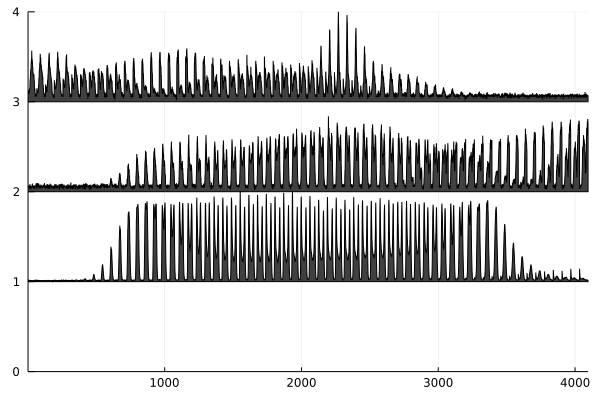

In [17]:
using StatsBase, Wavelets, WaveletsExt

idx = Vector{Int64}(undef, 3)
for i in 0:2
    label_idx = findall(yᵢ -> yᵢ == i, y)
    rand_idx = sample(label_idx)
    idx[i+1] = rand_idx
end

x = X̂[:,idx]
wiggle(x, sc=0.5)

# Local Discriminant Basis

In [23]:
wt = wavelet(WT.haar)
ldb = LocalDiscriminantBasis(wt, dm=SymmetricRelativeEntropy())

LocalDiscriminantBasis(OrthoFilter{Wavelets.WT.PerBoundary}([0.7071067811865476, 0.7071067811865476], "haar"), SymmetricRelativeEntropy(), TimeFrequency(), BasisDiscriminantMeasure(), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing)

In [24]:
Xw = Array{Float64,3}(undef, (4096,13,N))
for i in 1:N
    Xw[:,:,i] = wpd(X̂[:,i], wt)
end

In [25]:
WaveletsExt.fit!(ldb, Xw, y)

The following plot shows the nodes in the binary tree that produces the best set of coefficients/features.

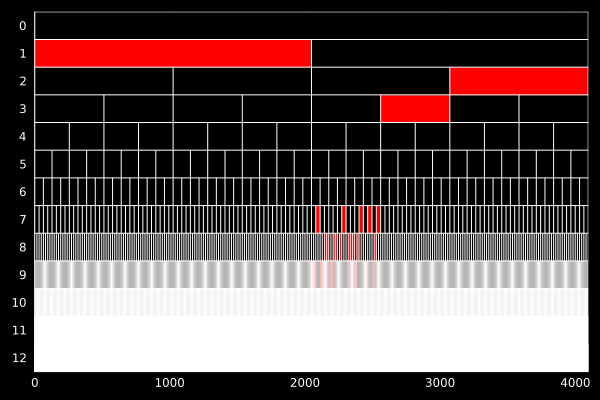

In [26]:
plot_tfbdry(ldb.tree, nodecolor=:red)

The following plot shows the descending discriminant power of coefficients. Based on the elbow rule, it seems like the top 1000 features will be useful.

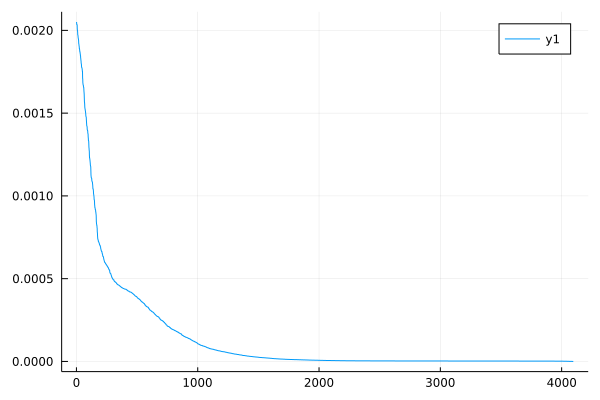

In [27]:
using Plots

plot(ldb.DP[ldb.order])